# HPT PyTorch Lightning: Diabetes Using a Recurrent Neural Network

In this tutorial, we will show how `spotPython` can be integrated into the `PyTorch` Lightning
training workflow for a regression task.

This chapter describes the hyperparameter tuning of a `PyTorch Lightning` network on the Diabetes data set. This is a PyTorch Dataset for regression. A toy data set from scikit-learn. Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients,  as well as the response of interest, a quantitative measure of disease progression one year after baseline.


## Step 1: Setup {#sec-setup-31}

* Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size, etc. 
* The parameter `MAX_TIME` specifies the maximum run time in seconds.
* The parameter `INIT_SIZE` specifies the initial design size.
* The parameter `WORKERS` specifies the number of workers. 
* The prefix `PREFIX` is used for the experiment name and the name of the log file.
* The parameter `DEVICE` specifies the device to use for training.

In [1]:
from spotPython.utils.device import getDevice
from math import inf
from spotPython.utils.file import get_spot_tensorboard_path

MAX_TIME = 1
FUN_EVALS = inf
INIT_SIZE = 5
WORKERS = 0
PREFIX="032"
DEVICE = getDevice()

::: {.callout-caution}
### Caution: Run time and initial design size should be increased for real experiments

* `MAX_TIME` is set to one minute for demonstration purposes. For real experiments, this should be increased to at least 1 hour.
* `FUN_EVALS` is set to infinity.
* `INIT_SIZE` is set to 5 for demonstration purposes. For real experiments, this should be increased to at least 10.
* `WORKERS` is set to 0 for demonstration purposes. For real experiments, this should be increased. See the warnings that are printed when the number of workers is set to 0.
* `PREFIX` is set to "032". This is used for the experiment name and the name of the log file.
* `DEVICE` is set to the device that is returned by `getDevice()`, e.g., `gpu`.
:::

::: {.callout-note}
### Note: Device selection

* Although there are no .cuda() or .to(device) calls required, because Lightning does these for you, see 
[LIGHTNINGMODULE](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html), we would like to know which device is used. Threrefore, we imitate the LightningModule behaviour which selects the highest device. 
* The method `spotPython.utils.device.getDevice()` returns the device that is used by Lightning.
:::


## Step 2: Initialization of the `fun_control` Dictionary

`spotPython` uses a Python dictionary for storing the information required for the hyperparameter tuning process.

In [2]:
from spotPython.utils.init import fun_control_init
import numpy as np

fun_control = fun_control_init(
    _L_in=10,
    _L_out=1,
    PREFIX=PREFIX,
    TENSORBOARD_CLEAN=True,
    device=DEVICE,
    enable_progress_bar=False,
    fun_evals=FUN_EVALS,
    log_level=10,
    max_time=MAX_TIME,
    num_workers=WORKERS,
    show_progress=True,
    test_size=0.1,
    tolerance_x=np.sqrt(np.spacing(1)),
    )

Seed set to 123


Moving TENSORBOARD_PATH: runs/ to TENSORBOARD_PATH_OLD: runs_OLD/runs_2024_01_07_19_54_36
Created spot_tensorboard_path: runs/spot_logs/032_p040025_2024-01-07_19-54-36 for SummaryWriter()


## Step 3: Loading the Diabetes Data Set

In [3]:
from spotPython.hyperparameters.values import set_control_key_value
from spotPython.data.diabetes import Diabetes
dataset = Diabetes()
set_control_key_value(control_dict=fun_control,
                        key="data_set",
                        value=dataset,
                        replace=True)
print(len(dataset))

442


::: {.callout-note}
### Note: Data Set and Data Loader

* As shown below, a DataLoader from `torch.utils.data` can be used to check the data.

In [4]:
# Set batch size for DataLoader
batch_size = 5
# Create DataLoader
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Iterate over the data in the DataLoader
for batch in dataloader:
    inputs, targets = batch
    print(f"Batch Size: {inputs.size(0)}")
    print(f"Inputs Shape: {inputs.shape}")
    print(f"Targets Shape: {targets.shape}")
    print("---------------")
    print(f"Inputs: {inputs}")
    print(f"Targets: {targets}")
    break

Batch Size: 5
Inputs Shape: torch.Size([5, 10])
Targets Shape: torch.Size([5])
---------------
Inputs: tensor([[ 0.0381,  0.0507,  0.0617,  0.0219, -0.0442, -0.0348, -0.0434, -0.0026,
          0.0199, -0.0176],
        [-0.0019, -0.0446, -0.0515, -0.0263, -0.0084, -0.0192,  0.0744, -0.0395,
         -0.0683, -0.0922],
        [ 0.0853,  0.0507,  0.0445, -0.0057, -0.0456, -0.0342, -0.0324, -0.0026,
          0.0029, -0.0259],
        [-0.0891, -0.0446, -0.0116, -0.0367,  0.0122,  0.0250, -0.0360,  0.0343,
          0.0227, -0.0094],
        [ 0.0054, -0.0446, -0.0364,  0.0219,  0.0039,  0.0156,  0.0081, -0.0026,
         -0.0320, -0.0466]])
Targets: tensor([151.,  75., 141., 206., 135.])


:::
## Step 4: Preprocessing {#sec-preprocessing-31}

Preprocessing is handled by `Lightning` and `PyTorch`. It is described in the [LIGHTNINGDATAMODULE](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) documentation. Here you can find information about the `transforms` methods.

## Step 5: Select the Core Model (`algorithm`) and `core_model_hyper_dict` {#sec-selection-of-the-algorithm-31}

`spotPython` includes the `NetLightRegression` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/netlightregression.py) for configurable neural networks. 
The class is imported here. It inherits from the class `Lightning.LightningModule`, which is the base class for all models in `Lightning`. `Lightning.LightningModule` is a subclass of `torch.nn.Module` and provides additional functionality for the training and testing of neural networks. The class `Lightning.LightningModule` is described in the [Lightning documentation](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html).

* Here we simply add the NN Model to the fun_control dictionary by calling the function `add_core_model_to_fun_control`:

In [5]:
from spotPython.light.regression.rnnlightregression import RNNLightRegression
from spotPython.light.regression.netlightregression import NetLightRegression
from spotPython.hyperdict.light_hyper_dict import LightHyperDict
from spotPython.hyperparameters.values import add_core_model_to_fun_control
add_core_model_to_fun_control(fun_control=fun_control,
                              # core_model=NetLightRegression,
                              core_model=RNNLightRegression,
                              hyper_dict=LightHyperDict)

The hyperparameters of the model are specified in the `core_model_hyper_dict` dictionary [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/hyperdict/light_hyper_dict.json).



## Step 6: Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model` {#sec-modification-of-hyperparameters-31}

 `spotPython` provides functions for modifying the hyperparameters, their bounds and factors as well as for activating and de-activating hyperparameters without re-compilation of the Python source code. 

::: {.callout-caution}
### Caution: Small number of epochs for demonstration purposes

* `epochs` and `patience` are set to small values for demonstration purposes. These values are too small for a real application.
* More resonable values are, e.g.:
  * `set_control_hyperparameter_value(fun_control, "epochs", [7, 9])` and
  * `set_control_hyperparameter_value(fun_control, "patience", [2, 7])`
:::

In [6]:
from spotPython.hyperparameters.values import set_control_hyperparameter_value

set_control_hyperparameter_value(fun_control, "l1", [5, 5])
set_control_hyperparameter_value(fun_control, "epochs", [7, 10])
set_control_hyperparameter_value(fun_control, "batch_size", [4, 5])
set_control_hyperparameter_value(fun_control, "optimizer", [
                "Adadelta",
                "Adagrad",
                "Adam",
                "AdamW",
                "Adamax",                
                "NAdam",
                "RAdam",
                "RMSprop",
                "Rprop"
            ])
set_control_hyperparameter_value(fun_control, "dropout_prob", [0.01, 0.2])
set_control_hyperparameter_value(fun_control, "lr_mult", [0.5, 5.0])
set_control_hyperparameter_value(fun_control, "patience", [5, 7])
set_control_hyperparameter_value(fun_control, "act_fn",["ReLU"] )

Now, the dictionary `fun_control` contains all information needed for the hyperparameter tuning. Before the hyperparameter tuning is started, it is recommended to take a look at the experimental design. The method `gen_design_table` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/utils/eda.py) generates a design table as follows:

In [7]:
#| fig-cap: Experimental design for the hyperparameter tuning.
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name           | type   | default   |   lower |   upper | transform             |
|----------------|--------|-----------|---------|---------|-----------------------|
| l1             | int    | 3         |    5    |     5   | transform_power_2_int |
| epochs         | int    | 4         |    7    |    10   | transform_power_2_int |
| batch_size     | int    | 4         |    4    |     5   | transform_power_2_int |
| act_fn         | factor | ReLU      |    0    |     0   | None                  |
| optimizer      | factor | SGD       |    0    |     8   | None                  |
| dropout_prob   | float  | 0.01      |    0.01 |     0.2 | None                  |
| lr_mult        | float  | 1.0       |    0.5  |     5   | None                  |
| patience       | int    | 2         |    5    |     7   | transform_power_2_int |
| initialization | factor | Default   |    0    |     2   | None                  |


This allows to check if all information is available and if the information is correct.

::: {.callout-note}
### Note: Hyperparameters of the Tuned Model and the `fun_control` Dictionary
The updated `fun_control` dictionary can be shown with the command `fun_control["core_model_hyper_dict"]`.
:::


## Step 7: Data Splitting, the Objective (Loss) Function and the Metric

### Evaluation  {#sec-selection-of-target-function-31}

The evaluation procedure requires the specification of two elements:

1. the way how the data is split into a train and a test set
2. the loss function (and a metric).

::: {.callout-caution}
### Caution: Data Splitting in Lightning

The data splitting is handled by `Lightning`.

:::

### Loss Function {#sec-loss-function-31}

The loss function is specified in the configurable network class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/regression/netlightregression.py)
We will use MSE.

### Metric {#sec-metric-31}

* Similar to the loss function, the metric is specified in the configurable network class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/regression/netlightregression.py).

::: {.callout-caution}
### Caution: Loss Function and Metric in Lightning

* The loss function and the metric are not hyperparameters that can be tuned with `spotPython`.
* They are handled by `Lightning`.

:::


## Step 8: Calling the SPOT Function

### Preparing the SPOT Call {#sec-prepare-spot-call-31}


In [8]:
from spotPython.utils.init import design_control_init, surrogate_control_init
design_control = design_control_init()
set_control_key_value(control_dict=design_control,
                        key="init_size",
                        value=INIT_SIZE,
                        replace=True)

surrogate_control = surrogate_control_init()
set_control_key_value(control_dict=surrogate_control,
                        key="noise",
                        value=True,
                        replace=True)                       
set_control_key_value(control_dict=surrogate_control,
                        key="n_theta",
                        value=2,
                        replace=True)      

### The Objective Function `fun` {#sec-the-objective-function-31}

The objective function `fun` from the class `HyperLight` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/fun/hyperlight.py) is selected next. It implements an interface from `PyTorch`'s training, validation, and testing methods to `spotPython`.

In [9]:
from spotPython.fun.hyperlight import HyperLight
fun = HyperLight(log_level=50).fun

### Showing the fun_control Dictionary {#sec-show-fun-control-31}

In [10]:
import pprint
pprint.pprint(fun_control)

{'CHECKPOINT_PATH': 'runs/saved_models/',
 'DATASET_PATH': 'data/',
 'RESULTS_PATH': 'results/',
 'TENSORBOARD_PATH': 'runs/',
 '_L_in': 10,
 '_L_out': 1,
 'accelerator': 'auto',
 'core_model': <class 'spotPython.light.regression.rnnlightregression.RNNLightRegression'>,
 'core_model_hyper_dict': {'act_fn': {'class_name': 'spotPython.torch.activation',
                                      'core_model_parameter_type': 'instance()',
                                      'default': 'ReLU',
                                      'levels': ['ReLU'],
                                      'lower': 0,
                                      'transform': 'None',
                                      'type': 'factor',
                                      'upper': 0},
                           'batch_size': {'default': 4,
                                          'lower': 4,
                                          'transform': 'transform_power_2_int',
                                          't

In [11]:
pprint.pprint(design_control)

{'init_size': 5, 'repeats': 1}


In [12]:
pprint.pprint(surrogate_control)

{'max_theta': 3,
 'min_theta': -3,
 'model_fun_evals': 10000,
 'model_optimizer': <function differential_evolution at 0x147ef8540>,
 'n_p': 1,
 'n_theta': 2,
 'noise': True,
 'optim_p': False,
 'seed': 124,
 'theta_init_zero': True,
 'var_type': None}


### Starting the Hyperparameter Tuning {#sec-call-the-hyperparameter-tuner-31}

The `spotPython` hyperparameter tuning is started by calling the `Spot` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/spot/spot.py).

In [13]:
from spotPython.spot import spot
spot_tuner = spot.Spot(fun=fun,
                       fun_control=fun_control,
                       design_control=design_control,
                       surrogate_control=surrogate_control)
spot_tuner.run()

Seed set to 123


train_model(): Test set size: 45
train_model(): Train set size: 359
train_model(): Batch size: 32


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type    | Params | In sizes | Out sizes          
----------------------------------------------------------------------------
0 | rnn_layer      | RNN     | 4.9 K  | [32, 10] | [[32, 64], [1, 64]]
1 | fc             | Linear  | 4.2 K  | [32, 64] | [32, 64]           
2 | output_layer   | Linear  | 65     | [32, 64] | [32, 1]            
3 | dropout1       | Dropout | 0      | [32, 10] | [32, 10]           
4 | dropout2       | Dropout | 0      | [32, 64] | [32, 64]           
5 | dropout3       | Dropout | 0      | [32, 64] | 

LightDataModule: train_dataloader(). Training set size: 359
LightDataModule: train_dataloader(). batch_size: 32
LightDataModule: train_dataloader(). num_workers: 0
Calling DataLoader()


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3078.626708984375     │
│         val_loss          │     3078.626708984375     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 3078.626708984375, 'hp_metric': 3078.626708984375}


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/spotPython/build/kriging.py:1040: RuntimeWarning: divide by zero encountered in log
  self.negLnLike = -1.0 * (-(self.n / 2.0) * log(self.SigmaSqr) - 0.5 * self.LnDetPsi)
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/spotPython/build/kriging.py:1040: RuntimeWarning: divide by zero encountered in log
  self.negLnLike = -1.0 * (-(self.n / 2.0) * log(self.SigmaSqr) - 0.5 * self.LnDetPsi)


spotPython tuning: 3078.626708984375 [##########] 100.00% Done...



/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


## Step 9: Tensorboard {#sec-tensorboard-31}

The textual output shown in the console (or code cell) can be visualized with Tensorboard.

```{raw}
tensorboard --logdir="runs/"
```

Further information can be found in the [PyTorch Lightning documentation](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.tensorboard.html) for Tensorboard.



## Step 10: Results {#sec-results-31}

After the hyperparameter tuning run is finished, the results can be analyzed.

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

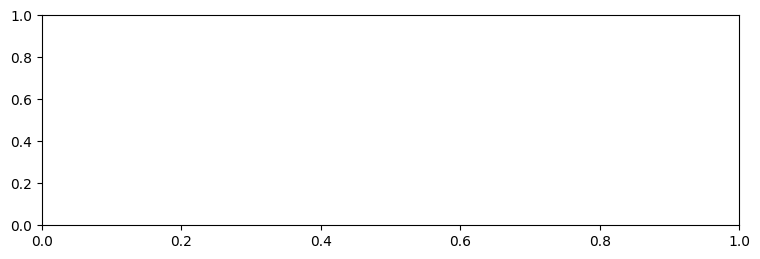

In [14]:
#| fig-cap: Progress plot. *Black* dots denote results from the initial design. *Red* dots  illustrate the improvement found by the surrogate model based optimization.
spot_tuner.plot_progress(log_y=False,
    filename="./figures/" + PREFIX + "_progress.png")

In [ ]:
#| fig-cap: Results of the hyperparameter tuning.
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

In [ ]:
#| fig-cap: 'Variable importance plot, threshold 0.025.'
spot_tuner.plot_importance(threshold=0.025,
    filename="./figures/" + PREFIX + "_importance.png")

### Get the Tuned Architecture {#sec-get-spot-results-31}

In [ ]:
from spotPython.hyperparameters.values import get_tuned_architecture
config = get_tuned_architecture(spot_tuner, fun_control)
print(config)

* Test on the full data set

In [ ]:
from spotPython.light.testmodel import test_model
test_model(config, fun_control)

In [ ]:
from spotPython.light.loadmodel import load_light_from_checkpoint

model_loaded = load_light_from_checkpoint(config, fun_control)

In [ ]:
#| fig-cap: Contour plots.
filename = "./figures/" + PREFIX
spot_tuner.plot_important_hyperparameter_contour(filename=filename)

### Parallel Coordinates Plot

In [ ]:
#| fig-cap: Parallel coordinates plots
spot_tuner.parallel_plot()

### Cross Validation With Lightning

* The `KFold` class from `sklearn.model_selection` is used to generate the folds for cross-validation.
* These mechanism is used to generate the folds for the final evaluation of the model.
* The `CrossValidationDataModule` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/data/lightcrossvalidationdatamodule.py) is used to generate the folds for the hyperparameter tuning process.
* It is called from the `cv_model` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/cvmodel.py).

In [ ]:
from spotPython.light.cvmodel import cv_model
set_control_key_value(control_dict=fun_control,
                        key="k_folds",
                        value=2,
                        replace=True)
set_control_key_value(control_dict=fun_control,
                        key="test_size",
                        value=0.1,
                        replace=True)
cv_model(config, fun_control)

### Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [ ]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)

### Visualizing the Activation Distribution (Under Development)

::: {.callout-note}
### Reference:

* The following code is based on [[PyTorch Lightning TUTORIAL 2: ACTIVATION FUNCTIONS]](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/02-activation-functions.html), Author: Phillip Lippe, License: [[CC BY-SA]](https://creativecommons.org/licenses/by-sa/3.0/), Generated: 2023-03-15T09:52:39.179933.

:::

After we have trained the models, we can look at the actual activation values that find inside the model. For instance, how many neurons are set to zero in ReLU? Where do we find most values in Tanh? To answer these questions, we can write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activations inside the network:

In [ ]:
from spotPython.torch.activation import Sigmoid, Tanh, ReLU, LeakyReLU, ELU, Swish
act_fn_by_name = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish}

In [ ]:
from spotPython.hyperparameters.values import get_one_config_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
config = get_one_config_from_X(X, fun_control)
model = fun_control["core_model"](**config, _L_in=64, _L_out=11)
model

In [ ]:
# from spotPython.utils.eda import visualize_activations
# visualize_activations(model, color=f"C{0}")